In [ ]:
!pip install ultralytics
!pip install -U ipywidgets
from ultralytics import YOLO
import torch

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

model.train(
    data='/kaggle/input/cv-project-files2/dataset.yaml',
    epochs=75,                            # Number of training epochs
    imgsz=640,                            # Image size
    batch=32,                             # batch size
    lr0=0.001,                             # initial learning rate
    augment=True,                         # no data augmentation
    dropout=0.2       ,                    # dropout to reduce overfitting
    device=[0,1]
)


In [ ]:
#from ultralytics import YOLO
# resume training
#model = YOLO('/kaggle/working/runs/detect/train/weights/last.pt')
#model.train(resume=True)

In [ ]:
image_folder = '/kaggle/input/large-license-plate-dataset/images/test/'
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

results = model(image_folder,stream=False)
output_folder = '/kaggle/working/test'
ok = 0
skip = 0
for image in results:
    device = image.boxes.xywh.device
    suitable_crops = torch.empty((0,6), device=device)
    for i in range(len(image)):
        x, y, w, h = image.boxes.xywh[i].tolist() 
        if w > 50 and h > 20:
            conf = image.boxes.conf[i]
            keep_crop = torch.tensor([[x-w/2,y-h/2,x+w/2,y+h/2,conf,0]],device=device)
            suitable_crops = torch.cat((suitable_crops,keep_crop))
            ok+=1
        else:
            skip+=1
    image.update(suitable_crops)
    image.save_crop(output_folder)

print("ok",ok,"skip",skip)

In [ ]:
# to save the run : zip the folder from this command and then download the zip file
#import shutil
#shutil.make_archive("train_20", 'zip', "/kaggle/working/runs/detect/train")

## PaddleOCR

In [1]:
!pip install paddlepaddle-gpu
!pip install paddleocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 2.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 148.8 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 190.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 92.4 MB/s eta 0:00:00:00:010:01
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=3973e524dc67584dff927605f75f4e0af0fcc446be4504db68ecf6613544a37b
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import pandas as pd
import os
from paddleocr import PaddleOCR
from PIL import Image
import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
from torchmetrics.text import CharErrorRate

In [3]:
def process_image(image):
    scaled_image = cv2.resize(image, (400, 300))
    gray_image = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2GRAY)
    gaussian_image = cv2.GaussianBlur(gray_image, (23, 23), 0)
    process_path = '/kaggle/working/preprocessed_license_plate.jpg'
    
    cv2.imwrite(process_path, gaussian_image)
    

def display_image(image, title="Image", cmap='gray'):
    plt.figure(figsize=(2, 2))  
    plt.imshow(image, cmap=cmap) 
    plt.title(title) 
    plt.axis('off')
    plt.show()

In [ ]:
import shutil
import os

In [14]:
source_file = ['/kaggle/input/cv-project-files2/model/config.yml','/kaggle/input/cv-project-files2/model/best_accuracy.pdopt','/kaggle/input/cv-project-files2/model/best_accuracy.pdparams','/kaggle/input/cv-project-files2/model/best_accuracy.states']
destination_dir = '/kaggle/working/model'

os.makedirs(destination_dir, exist_ok=True)

for file in source_file:
    destination_file = os.path.join(destination_dir, os.path.basename(file))
    shutil.copy(file, destination_file)

'/kaggle/working/model/config.yml'

In [4]:
csv_path = '/kaggle/input/license-plate-text-recognition-dataset/lpr.csv'  
images_folder = '/kaggle/input/license-plate-text-recognition-dataset/cropped_lps/cropped_lps'  
process_path = '/kaggle/working/preprocessed_license_plate.jpg'
trained_model_dir = '/kaggle/working/model'

ocr = PaddleOCR(use_gpu=True,lang="en",show_log=False, use_angle_cls=True,rec_model_dir=trained_model_dir)

data = pd.read_csv(csv_path)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:00<00:00, 9129.45it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /kaggle/working/model/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:00<00:00, 20882.07it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:00<00:00, 6160.84it/s]

[2024/12/11 19:52:52] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0


[2024/12/11 19:52:53] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0
[2024/12/11 19:52:55] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0


In [7]:
correct_count = 0
total_count = 0
cer_metric = CharErrorRate()

i = 0
for index, row in tqdm(data.iterrows(), total=len(data), mininterval=2):    
    if i < 5000:
        i+=1
        image_path = os.path.join(images_folder, row['images'])
        ground_truth = row['labels']
        image = cv2.imread(image_path)
        
        process_image(image)
        result = ocr.ocr(process_path, rec=True)
        if result and result[0]:
            recognized_text = result[0][0][1][0]
            recognized_text = re.sub(r'[^a-zA-Z0-9]', '', recognized_text)
        else:
            recognized_text = ""
        
        if recognized_text == ground_truth:
            correct_count += 1
            
        cer_metric.update([recognized_text], [ground_truth])            
        total_count+=1
    else:
        break
        
cer = cer_metric.compute().item() * 100
accuracy = (correct_count / total_count) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Character Error Rate (CER): {cer:.2f}%")

 25%|██▌       | 5000/20000 [02:51<08:35, 29.09it/s]

Accuracy: 63.00%
Character Error Rate (CER): 19.66%


# EasyOCR

In [1]:
!pip install numpy
!pip install easyocr
!pip install opencv-python
!pip install pandas
!pip install numpy

In [2]:
import os
import easyocr
import cv2
import pandas as pd
import numpy as np

In [3]:
images_path = '/kaggle/input/license-plate-text-recognition-dataset/cropped_lps/cropped_lps'
csv_path = '/kaggle/input/license-plate-text-recognition-dataset/lpr.csv' 

reader = easyocr.Reader(['en'], gpu=True)

data = pd.read_csv(csv_path)

In [4]:
def resize_image(image, target_height=200, target_width=600):
    original_height, original_width = image.shape[:2]

    scale_height = target_height / original_height
    scale_width = target_width / original_width

    scale_factor = min(scale_height, scale_width)

    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return resized_image


# def sharpen_image(image):
#    kernel = np.array([[0, -1, 0],
#                      [-1,  9, -1],
#                      [0, -1, 0]])
#    return cv2.filter2D(image, -1, kernel)

#def denoise_image(image):
#    return cv2.GaussianBlur(image, (5, 5), 0)


def process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Image {image_path} not found or could not be loaded.")
        return None
        
    resized_img = resize_image(img)
    
    # gray_immg = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    # gaussian_img = cv2.GaussianBlur(gray_image, (3, 3), 0)
    # enhanced_img = enhance_contrast(resized_img)
    # sharpened_img = sharpen_image(resized_img)
    # denoised_img = denoise_image(img)
    # gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    
    return resized_img

In [7]:
from torchmetrics.text import CharErrorRate

# initialising counters
correct_count = 0
total_count = 0

# Initialize CharErrorRate metric
cer_metric = CharErrorRate()

for index, row in data.iterrows():
    if total_count < 5000:
        image_path = os.path.join(images_path, row['images'])
        ground_truth = row['labels']

        processed_img = process_image(image_path)
        if processed_img is not None:
            ocr_results_processed = reader.readtext(processed_img, detail=1, decoder='beamsearch')

        recognized_text = ""
        if ocr_results_processed:
            for result in ocr_results_processed:
                text, confidence = result[1], result[2]
                if confidence > 0.5:
                    recognized_text = text.replace(" ", "").replace("-", "")

        # normalizing recognized text and ground truth for comparison
        recognized_text = recognized_text.strip().lower()
        ground_truth = ground_truth.strip().lower()

        # updating CER metric
        cer_metric.update([recognized_text], [ground_truth])

        # counting correct recognitions
        if recognized_text == ground_truth:
            correct_count += 1

        total_count += 1
    else:
        break

In [8]:
# computing final CER
cer = cer_metric.compute().item() * 100
# computing final accuracy
accuracy = (correct_count / total_count) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Character Error Rate (CER): {cer:.2f}%")

Accuracy: 12.36%
Character Error Rate (CER): 75.48%


# Tesseract OCR

In [1]:
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev
!pip install pytesseract python-Levenshtein


Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:3 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]   
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:5 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Hit:7 https://packages.cloud.google.com/apt google-fast-socket InRelease       
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:9 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [28.6 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1582 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1190 kB]
Get:12 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3428 kB]
Get:13

In [75]:
import os
import pandas as pd
import cv2
import pytesseract
from sklearn.metrics import accuracy_score
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import numpy as np
from pytesseract import Output
from difflib import SequenceMatcher

In [76]:
# Defining the paths
images_path = '/kaggle/input/license-plate-text-recognition-dataset/cropped_lps/cropped_lps'
csv_path = '/kaggle/input/license-plate-text-recognition-dataset/lpr.csv'

# Loading CSV containing ground truth
ground_truth = pd.read_csv(csv_path)

In [87]:
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Enhance contrast
    equalized = cv2.equalizeHist(gray)
    
    resized = cv2.resize(equalized, (1200, 600))
    
    return resized


# Function to compute similarity
def string_similarity(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()


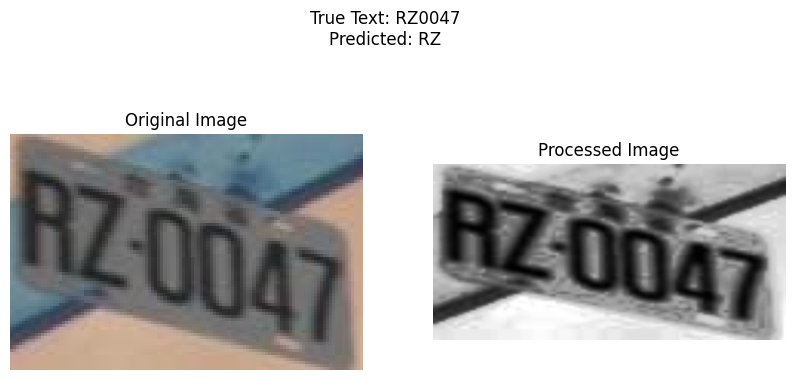

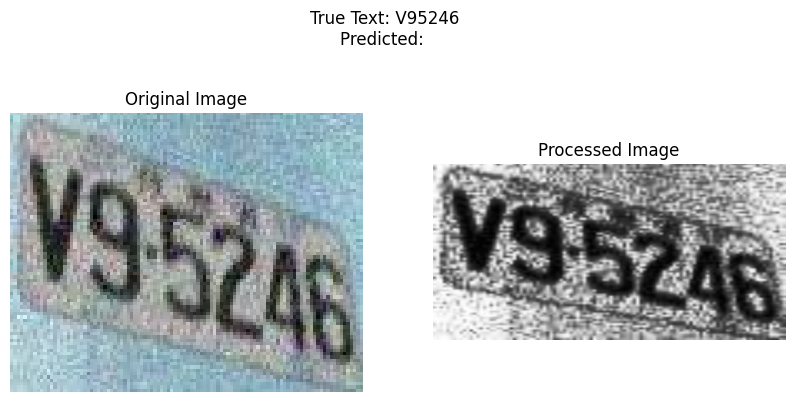

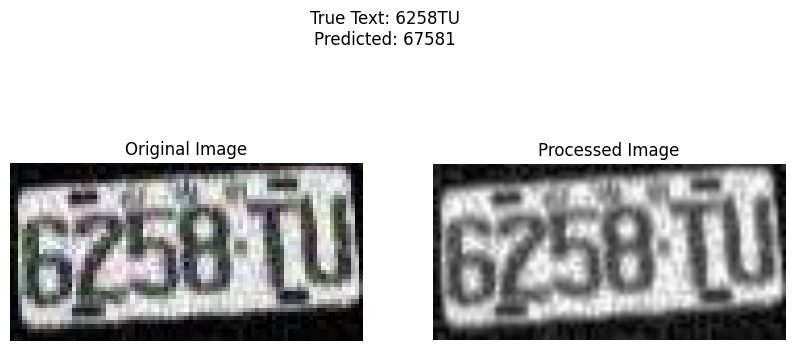

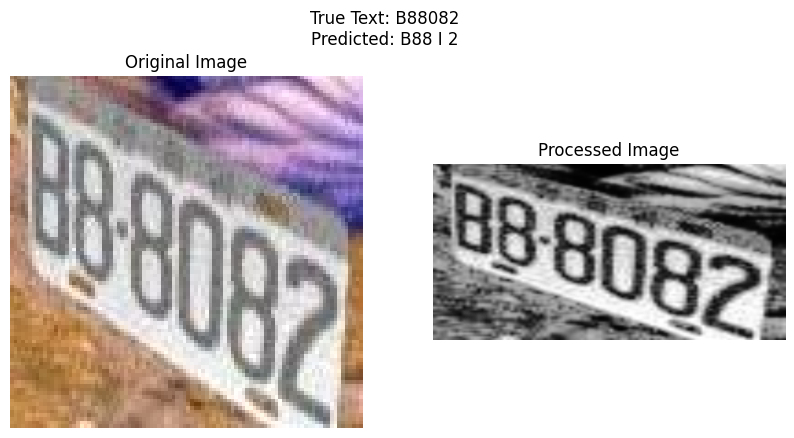

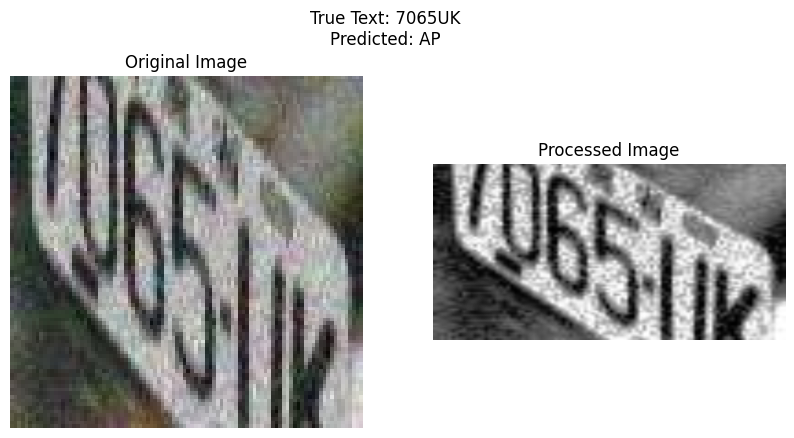

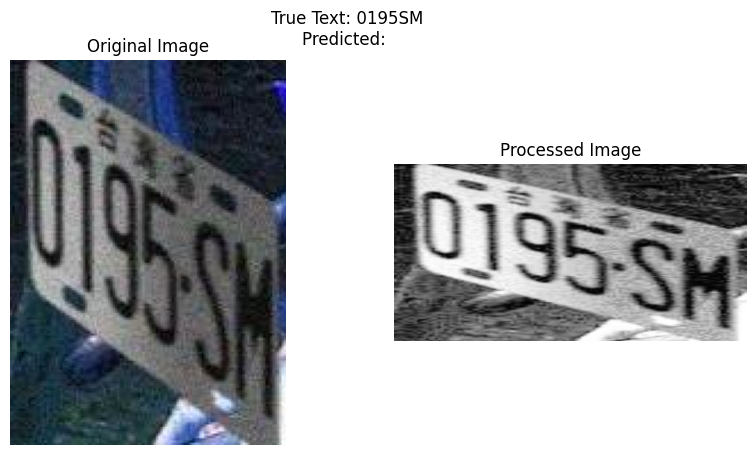

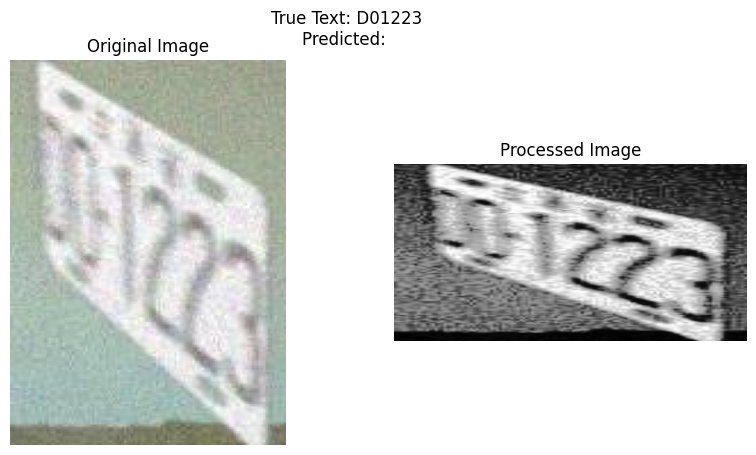

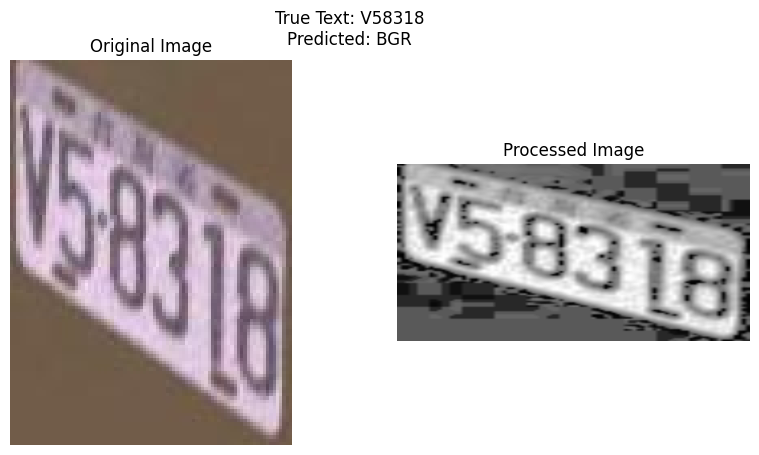

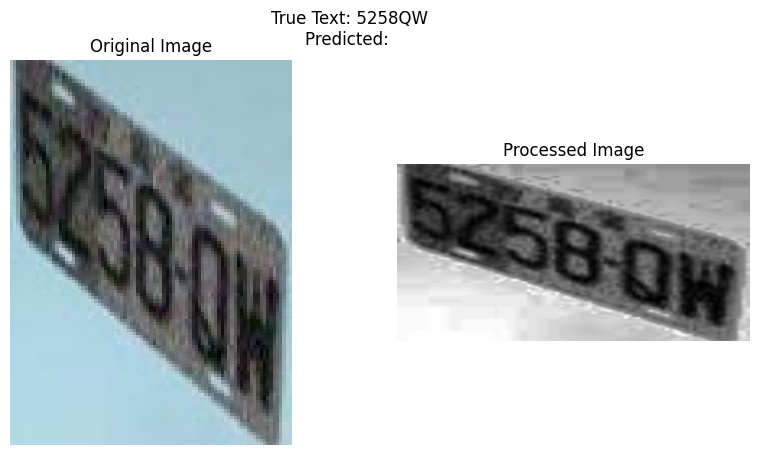

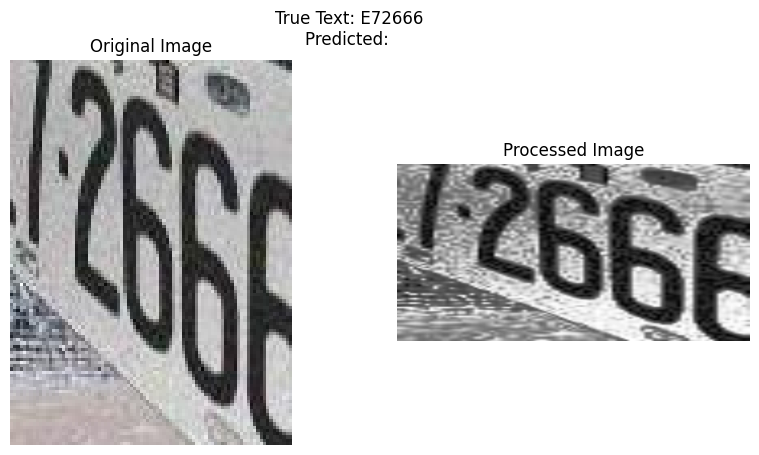

In [ ]:
true_texts = []
predicted_texts = []
similarity_scores = []

max_images = 1000
image_count = 0
visualization_count = 10

# Performing OCR
for index, row in ground_truth.iterrows():
    if image_count >= max_images:
        break 
        
    image_name = row['images']  
    true_text = row['labels']       
    
    image_path = os.path.join(images_path, image_name)
    
    if os.path.exists(image_path):
        # Preprocessing
        processed_image = preprocess_image(image_path)
        
        # Performing OCR using Tesseract

        config = '--psm 8 --oem 3 --tessdata-dir /usr/share/tesseract-ocr/4.00/tessdata --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
        ocr_text = pytesseract.image_to_string(processed_image, config=config)
        ocr_text = ocr_text.strip()  # Remove any leading/trailing whitespace
        
        # Appending to lists
        true_texts.append(true_text)
        predicted_texts.append(ocr_text)
        
        # Calculating similarity
        similarity = string_similarity(true_text, ocr_text)
        similarity_scores.append(similarity)

        if image_count < visualization_count:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            original_image = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
            plt.imshow(original_image)
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.title("Processed Image")
            plt.imshow(processed_image, cmap='gray')
            plt.axis('off')
            
            plt.suptitle(f"True Text: {true_text}\nPredicted: {ocr_text}")
            plt.show()

        image_count += 1
    else:
        print(f"Image not found: {image_path}")

In [81]:
# Calculating accuracy
accuracy = accuracy_score(true_texts, predicted_texts)
average_similarity = sum(similarity_scores) / len(similarity_scores)

# Displaying results
print(f"OCR Accuracy: {accuracy * 100:.2f}%")
print(f"Average Similarity Score: {average_similarity:.2f}")

# Saving results to CSV
results_df = pd.DataFrame({
    'True Text': true_texts,
    'Predicted Text': predicted_texts,
    'Similarity Score': similarity_scores
})
results_df.to_csv('/kaggle/working/ocr_results.csv', index=False)

print("Results saved to /kaggle/working/Tesseract_results.csv")

OCR Accuracy: 2.60%
Average Similarity Score: 0.24
Results saved to /kaggle/working/Tesseract_results.csv
